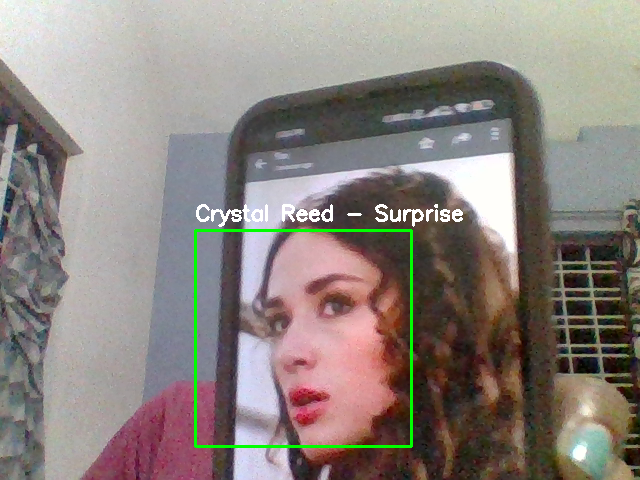

[INFO] Detection logged. Waiting 5 seconds...
[INFO] Webcam released.
[INFO] Attendance saved to attendance.csv


In [15]:
import cv2
import os
import numpy as np
import pandas as pd
from datetime import datetime
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from IPython.display import display, clear_output
import time

from keras.models import model_from_json

# Load model architecture from JSON
with open(r'C:\Users\USER\Desktop\Attendence Model\my_  model_1.json', 'r') as json_file:
    loaded_model_json = json_file.read()

emotion_model = model_from_json(loaded_model_json)

# Load weights into the model
emotion_model.load_weights(r'C:\Users\USER\Desktop\Emotion Detector\my_model_1.h5')


emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Face detection using Haar cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load known faces
known_face_vectors = []
known_face_names = []

def extract_face_features(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(gray, (100, 100))
        face = face.astype("float32") / 255.0
        return face.flatten()
    except:
        return None

dataset_path =  r'C:\Users\USER\Desktop\Attendence Model\dataset'
for person_name in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person_name)
    if os.path.isdir(person_folder):
        for img_file in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_file)
            img = cv2.imread(img_path)
            vec = extract_face_features(img)
            if vec is not None:
                known_face_vectors.append(vec)
                known_face_names.append(person_name)

print("[INFO] Loaded known faces:", known_face_names)

# Initialize webcam
cap = cv2.VideoCapture(0)
attendance_data = {}
max_detections = 3
detections_done = 0
pause_seconds = 5  # wait time after each detection

try:
    while detections_done < max_detections:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.2, minNeighbors=5)

        detected_this_round = False

        for (x, y, w, h) in faces:
            face_roi = frame[y:y+h, x:x+w]
            face_vec = extract_face_features(face_roi)
            name = "Unknown"

            if face_vec is not None:
                sims = cosine_similarity([face_vec], known_face_vectors)[0]
                best_match_idx = np.argmax(sims)
                if sims[best_match_idx] > 0.7:
                    name = known_face_names[best_match_idx]

            # Emotion Detection
            try:
                gray_face = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
                roi = cv2.resize(gray_face, (48, 48))
                roi = roi.astype("float") / 255.0
                roi = img_to_array(roi)
                roi = np.expand_dims(roi, axis=0)

                emotion_prediction = emotion_model.predict(roi, verbose=0)
                emotion_label = emotion_labels[np.argmax(emotion_prediction)]
            except:
                emotion_label = "Unknown"

            # Log attendance only if not already recorded
            if name != "Unknown" and name not in attendance_data:
                attendance_data[name] = {
                    'Emotion': emotion_label,
                    'Time': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                }
                detections_done += 1
                detected_this_round = True

            # Annotate frame
            label = f"{name} - {emotion_label}"
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            break  # Only process the first detected face

        # Show in notebook
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_frame)
        clear_output(wait=True)
        display(pil_image)

        if detected_this_round:
            print(f"[INFO] Detection logged. Waiting {pause_seconds} seconds...")
            time.sleep(pause_seconds)

except KeyboardInterrupt:
    print("[INFO] Interrupted manually.")

finally:
    cap.release()
    print("[INFO] Webcam released.")

# Save attendance to CSV
df = pd.DataFrame([{
    'Name': name,
    'Emotion': data['Emotion'],
    'Time': data['Time']
} for name, data in attendance_data.items()])
df.to_csv("attendance.csv", index=False)
print("[INFO] Attendance saved to attendance.csv")


In [19]:
import importlib.metadata

required_packages = [
    "tensorflow",         # For keras models
    "numpy",              # For numerical operations
    "opencv-python",      # For cv2
    "pandas",             # For handling CSV and tabular data
    "scikit-learn",       # For cosine similarity
    "Pillow",             # For PIL image support
    "ipython",            # For IPython.display in notebooks
]

with open("requirements.txt", "w") as f:
    for package in required_packages:
        try:
            version = importlib.metadata.version(package)
            f.write(f"{package}=={version}\n")
        except importlib.metadata.PackageNotFoundError:
            print(f"Warning: {package} is not installed.")
            f.write(f"{package}\n")  # Write without version if not installed

print("requirements.txt file with exact versions has been created.")


requirements.txt file with exact versions has been created.
